### Next sample strategy

Considered strategies used to propose the next problem:
1. Randomly sample from the dataset D. Does not model the student and is therefore unable to adapt to their ability. May present redundant teaching examples of concepts that have already been learned by the student and not reinforce concepts that the student has shown to be uncertain about.
2. ~~Worst predicted. Related to uncertainty sampling used in Active Learning. Selects the next teaching image whose prediction deviates most from the ground truth. Prone to proposing outliers. In the learning to program problem, maybe it presents the hardest exercises?~~
3. Expected Error Reduction. Chooses the teaching image which, if labeled correctly, would have the greatest reduction on the future error over the images that are not in the teaching set. Student’s conditional distribution given the teaching set can be approximated using Gaussian Random Field.

#### Import libraries

In [1]:
# Input
# from db import PythonProblems
# import io

# Helpers
import numpy as np

# Preprocessing
# import tokenize
# from sklearn.feature_extraction.text import CountVectorizer

# Distance
# from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity, rbf_kernel, euclidean_distances

# Learning
from clustering import Clustering
from plot2d import Plot2D

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from generate_pdf import PDFReport

%matplotlib inline

#### Get next sample

In [2]:

########################################################################
# Date: June 2015
# Author: Edward Johns (e.johns@imperial.ac.uk)
# This code may be freely distributed, but citations should be made to:
# E. Johns et al, "Becoming the Expert - Interactive Multi-Class Machine Teaching", in Proceedings of CVPR 2015
########################################################################

def get_next_sample(X, Y, W, L):

    # Based on "Zhu et al., Combining Active Learning and Semi-Supervised Learning Using Gaussian Fields and Harmonic Functions, in ICML workshop 2003"

    # Input:
    # Below, nS = total number of samples, nC = number of classes, nL = number of observed samples, nT = total number of testing samples to be shown to user
    # X: nS*nC belief matrix, with each row representing one sample, and each column representing one column. Each element is the probability that the user thinks that sample is assigned to that class. This would be identical to Y if we were assuming that the user always assigns the ground truth to an observed sample, and never has memory fall-off.
    # Y: nS*nC ground truth matrix (NumPy array), with each row in indicator encoding. This represents the ground-truth labels of all points. As such, each row has only one "1" and all other entries are "0".
    # W: nS*nS graph weights matrix (symmetrical NumPy array), with each row and each column corresponding to one sample. Each element is the weight (affinity) between two samples.
    # L: nL*1 labeled set, where each element is one sample that has already been shown to the user, with indices between 1 and nS.
    # Output:
    #    next_sample: the index of the optimum sample to be shown next, as selected by the active teaching algorithm.

    # Get the total number of samples (nS) and total number of classes (nC). nC is not actually used.
    [nS, nC] = X.shape

    # Create the set of unlabelled samples (U)
    U = np.setdiff1d(np.arange(nS), L)

    # Get the number of unlabelled samples (nU)
    nU = len(U)

    # Get the ground truth for the unlabelled samples
    Yu = Y.take(U, 0)

    # Get the unlabelled section of the covariance matrix
    Delta = np.subtract(np.diag(np.sum(W, 1)), W)
    ## To understand the take functions
    ## Delta.take(U,0) = Delta[U,:]
    ## Delta.take(U,1) = Delta[:,U]
    ## Delta.take(U, 0).take(U, 1) = Delta[U,:][:, U]
    ## It filters for every unlabeled row, the unlabeled columns.
    invDeltaU = np.linalg.inv(Delta.take(U, 0).take(U, 1))

    # Get the current state of the GRF, for the unlabeled samples
    ## W[U, :][:,L] = W.take(U, 0).take(L, 1)
    ## X[L, :] = X.take(L, 0)
    ## Why W and not Delta?? Delta is the negative of W for indices that are not ii.
    ## Not sure why original implementation chose W and not Delta
#     f = np.dot(invDeltaU, np.dot(W.take(U, 0).take(L, 1), X.take(L, 0)))
#     print(f)
    # Mean value of the unlabeled data points
    f = np.dot(-invDeltaU, np.dot(Delta.take(U, 0).take(L, 1), X.take(L, 0)))
#     print(f)

    # Create a list of risks, one for each unlabelled sample
    uRisks = np.zeros(nU)

    # Try each unlabelled sample
    for u in range(nU):
        # Find the sample number (remember that U is just the list of unlabelled samples, not all the samples)
        s = U[u]

        # Calculate the new state of the GRF if this sample were to be revealed to the user (here, we assume 
        # that the user's belief of this sample will then be the ground truth -- debatable...)
        GG = invDeltaU[:, u] / invDeltaU[u, u]
        diff = Y[s, :] - f[u, :]
        fPlus = f + np.dot(GG[..., np.newaxis], diff[np.newaxis, ...])

        # Sum up the risks over all unlabelled points (i.e. the difference between the new state, and the 
        # ground truth)
#         D = np.abs(1 - fPlus[Yu == 1])
        # Don't understand why the need of ABS. Maybe because it was negative when using W and not Delta?
        D = 1 - fPlus[Yu == 1]
        uRisks[u] = np.sum(D)

    # Get the sample which minimised the risk
    next_sample_index = np.argmin(uRisks)
    next_sample = U[next_sample_index]

    # Return this sample
    return next_sample, uRisks

### Generate synthetic data

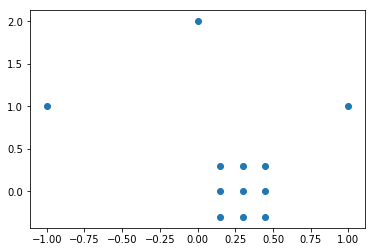

In [3]:
# Generate data
sample = np.zeros((400,2))

for x in range(0,4):
    for y in np.arange(-0.3,0.31,0.3):
        sample[idx] = [x,y]
        idx+=1
        
plt.scatter(x=sample[:,0], y=sample[:,1])

In [4]:
X = np.zeros((12,2))
X[0] = [0,1]
X[1] = [1,0]
print(X.shape)

Y = np.zeros((12,2))
Y[0] = [0,1]
Y[1] = [1,0]
Y[2] = [0,1]
for i in range(3,Y.shape[0]):
    Y[i] =[1,0]
print(Y.shape)

# Create W as a similarity matrix
# W = cosine_similarity(clustering.X) # nS x nS
W = rbf_kernel(sample, gamma=1) # nS x nS
print(W.shape)

# Set L as an unlabelled set
L = [0, 1]

(12, 2)
(12, 2)
(12, 12)


$d_i = \sum_j w_{ij}$

$D = diag(d_i)$

The *combinatorial Laplacian* is the $n x n$ matrix:

$\Delta = D - W$

We partition the Laplacian matrix $\Delta$ into blocks for labeled and unlabeled nodes:

$\Delta = \begin{bmatrix}
\Delta_{ll} & \Delta_{lu} \\ 
\Delta_{ul} & \Delta_{uu} \\
\end{bmatrix}$

The harmonic minimizing function $f$ is defined as:

$f = \begin{bmatrix}
f_l \\
f_u
\end{bmatrix}$ where $fl = y_L$ and **$f_u$ denotes the mean values on the unlabeled data points**. The solution is given by:

$f_u = -\Delta_{uu}^{-1}\Delta_{ul}f_l$

The *true* risk $R(f)$ of the Bayes classifier based on the harmonic function $f$ is

$$R(f) = \sum_{i=1}^{n} \sum_{y_i=C_j}^{C_m} \left [ y_i \neq C_j \right ] p^\ast(y_i|L)$$

**This is the probability (weighted sum) that the class DOES NOT belong to the ground truth.**

Here, $p^\ast(y_i|L)$ is the unknown true label distribution at node $i$ given the labeled data. In order to proceed, we estimate this unknown distribution with the mean of the Gaussian field model:

$p^\ast(y_i=C|L)\approx f_{iC}$

The risk can then be written as:

$\hat{R}(f) = \sum_{i=1}^{n} 1 - \left[ y_i = C\right] p^{\ast}(yi=C|L)$

Performing active learning and querying an unlabeled node $k$, we will receive an answer $y_k$. Adding this point to the training set and retraining, the Gaussian field and its mean function will change. The new harmonic function is denoted by $f^{+(x_k,y_k)}$

The active learning criterion here is the greedy procedure of choosing the next query $k$ that minimizes the expected estimated risk:

$k = argmin_{k'}\hat{R}(f^{+x_{k'}})$

And  $f^{+(x_k,y_k)}$ can be calculated as:

$f_{u}^{+(x_k,y_k)} = f_u + (y_k - f_k) \frac{(\Delta_{uu}^{-1})_k}{(\Delta_{uu}^{-1})_{kk}}$

where $(\Delta_{uu}^{-1})_{k}$ of the $k$-th column of the inverse Laplacian on the unlabeled data, and $(\Delta_{uu}^{-1})_{kk}$ is the $k$-th diagonal element of the same matrix.

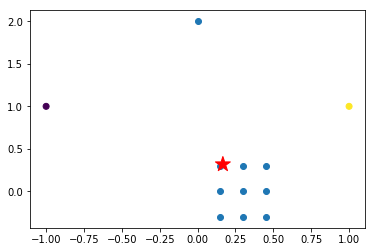

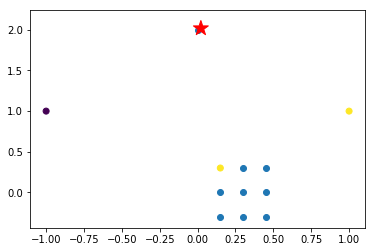

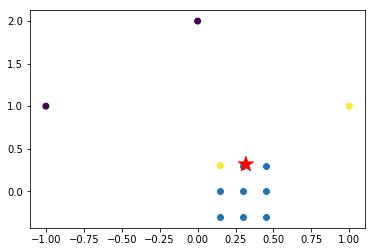

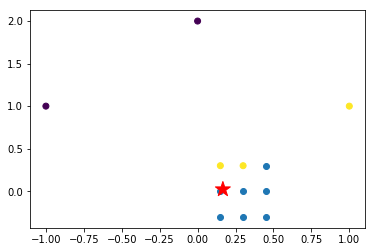

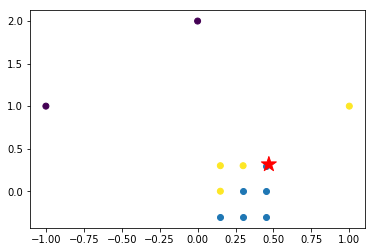

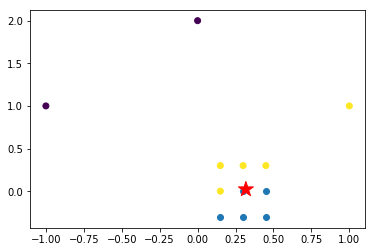

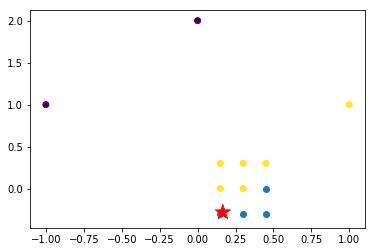

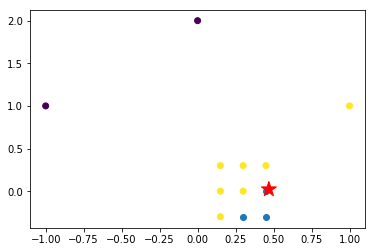

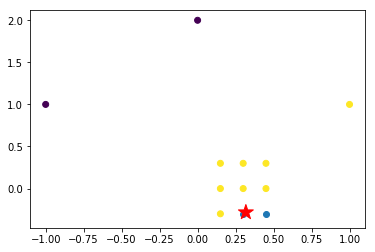

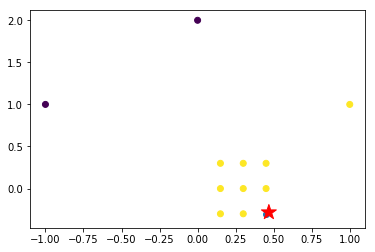

In [5]:
doc = PDFReport()
for i in range(10):
    # Get next sample
    sample_id, uRisks = get_next_sample(X, Y, W, L)
    
    # Plot sample
    plt.figure()
    
    # Get the total number of samples (nS) and total number of classes (nC). nC is not actually used.
    [nS, nC] = X.shape
    # Create the set of unlabelled samples (U)
    U = np.setdiff1d(np.arange(nS), L)
    # Plot unlabeled samples
    plt.scatter(x=sample[U,0], y=sample[U,1])
    
    # Color by class the ones already labeled
    plt.scatter(x=sample[L,0], y=sample[L,1], c=Y[L,0])
    
    # Star the queried sample
    plt.scatter(x=sample[sample_id,0], y=sample[sample_id,1], color='r', marker=r'$\star$', s=400)
    
    # Save figure
    plt.savefig("images/solution_%d.png" % sample_id)
#     print("Question %d" % sample_id)
    
    # Print question
#     problem = questions[sample_id]
#     solution = solutions[sample_id]
    
    # Suppose that the student gets it correctly
    # Update X matrix
    X[sample_id] = Y[sample_id]
    L.append(sample_id)
    doc.append_solution(sample_id, '', '')

doc.generate_pdf("synthetic_trajectory1")

### References
[1] Johns, E., Aodha, O. Mac & Brostow, G. J. Becoming the expert - Interactive multi-class machine teaching. in Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition (2015). doi:10.1109/CVPR.2015.7298877

[2] Zhu, X., Lafferty, J. & Ghahramani, Z. Combining Active Learning and Semi-Supervised Learning Using Gaussian Fields and Harmonic Functions Xiaojin. … Data Mach. Learn. … (2003).